
👉 Upload MASTER DATABASE (baseline CSV)


Saving master_db.csv to master_db.csv

👉 Upload CURRENT DATABASE (latest CSV)


Saving current_db.csv to current_db.csv

MASTER rows: 5000
CURRENT rows: 5000


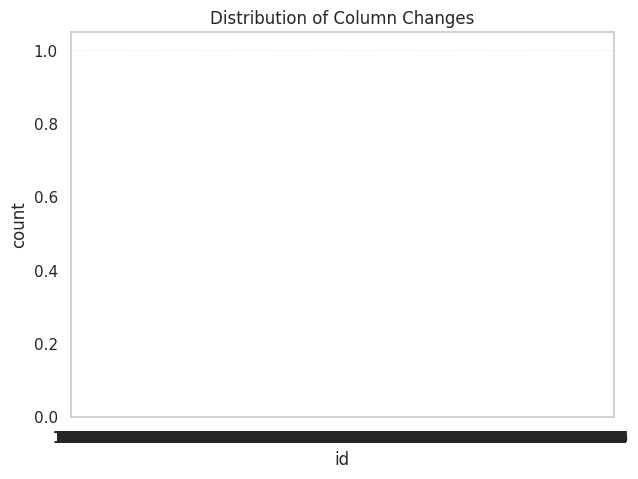

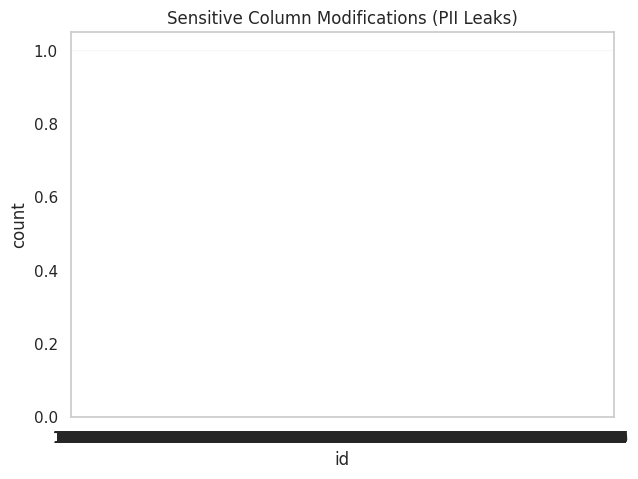

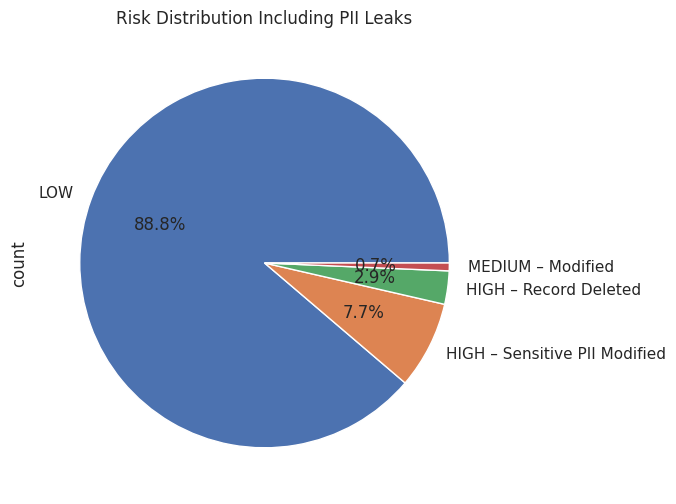


🚨 HIGH-RISK ANOMALIES (PII & Deletions):


,missing_flag,new_flag,changed_cols,pii_flag,anomaly_score,anomaly,risk
id,,,,,,,
1114,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1240,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1366,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1409,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1412,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1470,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1531,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1604,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1640,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified



📁 Report saved as: data_leak_report_pii.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 Scan Completed with PII Security Enhancements!

Interpretation:
 - missing_flag = 1 → record deleted → possible leak
 - new_flag = 1 → unknown new record added
 - changed_cols > 0 → modification detected
 - pii_flag = 1 → sensitive data modified
 - anomaly = 1 → IsolationForest flagged as unusual



In [4]:
# ============================================================
# AI–POWERED DATA LEAK DETECTION SYSTEM (Enhanced with PII Security)
# With EDA + Visualizations + Analytics + ML + Security Challenges
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.ensemble import IsolationForest
import joblib
import io

sns.set(style="whitegrid")

# ============================================================
# 1. UPLOAD MASTER & CURRENT DATABASE
# ============================================================

print("\n👉 Upload MASTER DATABASE (baseline CSV)")
uploaded_master = files.upload()

print("\n👉 Upload CURRENT DATABASE (latest CSV)")
uploaded_current = files.upload()

master_path = list(uploaded_master.keys())[0]
current_path = list(uploaded_current.keys())[0]

master_df = pd.read_csv(master_path, dtype=str).fillna("")
current_df = pd.read_csv(current_path, dtype=str).fillna("")

print("\nMASTER rows:", len(master_df))
print("CURRENT rows:", len(current_df))

# ============================================================
# 2. CONFIGURATION
# ============================================================

UNIQUE_KEY = "id"  # update if needed
SENSITIVE_COLS = ["email", "phone", "ssn"]  # add your sensitive columns here

compare_cols = [c for c in master_df.columns if c != UNIQUE_KEY]

# ============================================================
# 3. SYNTHETIC PII LEAK SIMULATION
# ============================================================

def simulate_pii_leaks(df, leak_ratio=0.01):
    """
    Randomly modify sensitive columns to simulate subtle leaks.
    leak_ratio = % of rows to corrupt
    """
    df_leak = df.copy()
    n = int(len(df_leak) * leak_ratio)
    leak_rows = np.random.choice(df_leak.index, n, replace=False)

    for col in SENSITIVE_COLS:
        if col in df_leak.columns:
            df_leak.loc[leak_rows, col] = df_leak.loc[leak_rows, col].apply(lambda x: str(x) + "_LEAK")

    return df_leak

# Apply synthetic PII leaks to CURRENT DB for testing
current_df = simulate_pii_leaks(current_df, leak_ratio=0.02)  # 2% subtle leaks

# ============================================================
# 4. FEATURE ENGINEERING FOR ML
# ============================================================

master_idx = master_df.set_index(UNIQUE_KEY)
current_idx = current_df.set_index(UNIQUE_KEY)
all_ids = sorted(list(set(master_idx.index) | set(current_idx.index)))

records = []

def count_diff(master_row, curr_row):
    diff_count = 0
    pii_diff = 0
    for c in compare_cols:
        if str(master_row.get(c, "")) != str(curr_row.get(c, "")):
            diff_count += 1
            if c in SENSITIVE_COLS:
                pii_diff += 1
    return diff_count, pii_diff

for rid in all_ids:
    in_master = int(rid in master_idx.index)
    in_current = int(rid in current_idx.index)

    master_row = master_idx.loc[rid].to_dict() if in_master else {}
    curr_row = current_idx.loc[rid].to_dict() if in_current else {}

    num_diff, pii_diff = count_diff(master_row, curr_row)

    records.append({
        UNIQUE_KEY: rid,
        "missing_flag": 1 if (in_master and not in_current) else 0,
        "new_flag": 1 if (in_current and not in_master) else 0,
        "changed_cols": num_diff,
        "pii_flag": 1 if pii_diff > 0 else 0  # Flag if sensitive column modified
    })

features_df = pd.DataFrame(records).set_index(UNIQUE_KEY)

# ============================================================
# 5. VISUALIZATIONS
# ============================================================

plt.figure(figsize=(7,5))
sns.countplot(features_df["changed_cols"])
plt.title("Distribution of Column Changes")
plt.show()

plt.figure(figsize=(7,5))
sns.countplot(features_df["pii_flag"])
plt.title("Sensitive Column Modifications (PII Leaks)")
plt.show()

# ============================================================
# 6. TRAIN ISOLATION FOREST (UNSUPERVISED ML)
# ============================================================

iso = IsolationForest(
    n_estimators=200,
    contamination=0.02,
    random_state=42
)

X = features_df[["missing_flag", "new_flag", "changed_cols", "pii_flag"]].astype(float)
iso.fit(X)

features_df["anomaly_score"] = iso.decision_function(X)
features_df["anomaly"] = pd.Series(iso.predict(X), index=features_df.index).replace({-1: 1, 1: 0})

# ============================================================
# 7. RISK MAPPING INCLUDING PII
# ============================================================

def risk_level(row):
    if row["missing_flag"] == 1:
        return "HIGH – Record Deleted"
    if row["pii_flag"] == 1:
        return "HIGH – Sensitive PII Modified"
    if row["new_flag"] == 1:
        return "MEDIUM – New Record Added"
    if row["changed_cols"] > 0:
        return "MEDIUM – Modified"
    return "LOW"

features_df["risk"] = features_df.apply(risk_level, axis=1)

plt.figure(figsize=(6,6))
features_df["risk"].value_counts().plot.pie(autopct="%1.1f%%")
plt.title("Risk Distribution Including PII Leaks")
plt.show()

# ============================================================
# 8. SHOW HIGH-RISK ANOMALIES
# ============================================================

print("\n🚨 HIGH-RISK ANOMALIES (PII & Deletions):")
display(features_df[features_df["anomaly"] == 1].head(20))

# ============================================================
# 9. SAVE REPORT
# ============================================================

output_file = "data_leak_report_pii.csv"
features_df.to_csv(output_file)
print("\n📁 Report saved as:", output_file)
files.download(output_file)

print("\n🎯 Scan Completed with PII Security Enhancements!")
print("""
Interpretation:
 - missing_flag = 1 → record deleted → possible leak
 - new_flag = 1 → unknown new record added
 - changed_cols > 0 → modification detected
 - pii_flag = 1 → sensitive data modified
 - anomaly = 1 → IsolationForest flagged as unusual
""")

In [5]:
import re

# Automatically detect PII columns based on content
SENSITIVE_COLS = []

sample_rows = current_df.head(100)  # sample first 100 rows to detect patterns

for col in current_df.columns:
    if current_df[col].dtype == object:
        for val in sample_rows[col]:
            if isinstance(val, str):
                if re.match(r".+@.+\..+", val):  # simple email detection
                    SENSITIVE_COLS.append(col)
                    break
                if re.match(r"\+?\d{10,15}", val):  # phone number
                    SENSITIVE_COLS.append(col)
                    break
                if re.match(r"\d{3}-\d{2}-\d{4}", val):  # SSN
                    SENSITIVE_COLS.append(col)
                    break

SENSITIVE_COLS = list(set(SENSITIVE_COLS))
print("Detected PII Columns:", SENSITIVE_COLS)

Detected PII Columns: ['email', 'phone']


In [6]:
# ============================================================
# 8. SHOW HIGH-RISK ANOMALIES
# ============================================================

print("\n🚨 HIGH-RISK ANOMALIES (PII & Deletions):")
display(features_df[features_df["anomaly"] == 1].head(20))

# ============================================================
# 9. SAVE REPORT
# ============================================================

output_file = "data_leak_report_pii.csv"
features_df.to_csv(output_file)
print("\n📁 Report saved as:", output_file)
files.download(output_file)

print("\n🎯 Scan Completed with PII Security Enhancements!")
print("""
Interpretation:
 - missing_flag = 1 → record deleted → possible leak
 - new_flag = 1 → unknown new record added
 - changed_cols > 0 → modification detected
 - pii_flag = 1 → sensitive data modified
 - anomaly = 1 → IsolationForest flagged as unusual
""")


🚨 HIGH-RISK ANOMALIES (PII & Deletions):


,missing_flag,new_flag,changed_cols,pii_flag,anomaly_score,anomaly,risk
id,,,,,,,
1114,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1240,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1366,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1409,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1412,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1470,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1531,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1604,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified
1640,0,0,1,1,-0.008593,1,HIGH – Sensitive PII Modified



📁 Report saved as: data_leak_report_pii.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 Scan Completed with PII Security Enhancements!

Interpretation:
 - missing_flag = 1 → record deleted → possible leak
 - new_flag = 1 → unknown new record added
 - changed_cols > 0 → modification detected
 - pii_flag = 1 → sensitive data modified
 - anomaly = 1 → IsolationForest flagged as unusual

